# Model Analysis

The script guides through the counting of reactions in each compartment and the generation of the Venn diagramm for reaction overlap of the two K. phaffii models iMT1026, iRY1243 and the O. polymorpha model iUL909.

In [1]:
import sys # loading commands to control/navigate within the system architecture
# Loading pandas, a library for data manipulation
import os
import xlrd
import pandas as pd
import re
# import lxml

# Loading numpy, a library fo manipulation of numbers
import numpy as np

# loading matplotlib, a library for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite

# additional functions to count and assign reaction in compartments

In [2]:
def countCinFormula(formula):
    '''
    Counting C-atoms of metabolite in cobra model
    
    Argument:
    formula: string, the metabolite formula from the cobra model
    
    Return:
    int, number of C-atoms in formula
    '''
    return int(re.search(r'C(.*)H',formula).group(1)) if re.search(r'C(.*)H',formula).group(1) else int(1)

def set_ObjGSMM(model, Product):
    '''
    Adding boundary flux for a desired product and setting the objective reaction to the product in the model.
    
    Arguments:
    model: cobra model, iUma22
    Product: string, model metabolite ID
    
    Return:
    cobra model, updated with a demand flow for the product and optimization of the new demand reaction.
    '''
    model.add_boundary(model.metabolites.get_by_id(Product), type='demand')
    model.objective = 'DM_{}'.format(Product)
    return model

def set_SubiOpol(model, Sub, Flux):
    '''
    Setting the desired substrate in the model.
    
    Arguments:
    model: cobra model, iOpol909
    Sub: string/list, model metabolite ID
    Flux: float, desired substrate uptake rate
    
    Return:
    cobra model, updated with designed (co-) substrate uptake rates.
    '''
    model.reactions.get_by_id('Ex_glc_D').lower_bound = 0
    model.reactions.get_by_id('Ex_{}'.format(Sub[0])).lower_bound = -Flux
    return model

In [11]:
# generating cobra variable from SBML/xml file
# assuming the base path is in 'Simulation'
iUL909_File = os.path.join('..','model','iUL909.xml') # os.path.join('..','iUL_versions','iUL959_112718.xml')
model = read_sbml_model(iUL909_File)

# iMT1026_File = os.path.join('..','data','ReferenceModels','iMT1026v3.xml') # os.path.join('..','iUL_versions','iUL959_112718.xml')
# iMT1026 = read_sbml_model(iMT1026_File)

# iRY1243_File = os.path.join('..','data','ReferenceModels','iRY1243.xml') # os.path.join('..','iUL_versions','iUL959_112718.xml')
# iRY1243 = read_sbml_model(iRY1243_File)


## Finding metabolites in model

In [33]:
# Searching for metabolite IDs
CheckMet = 'Mal'
[print('{}:\t{}:\t{}:\t{}\n'.format(MetID.name, MetID.id, MetID.formula, MetID.annotation)) for MetID in model.metabolites.query(CheckMet, 'name')];

4-Maleylacetoacetate:	4mlacac[c]:	C8H6O6:	{'kegg.compound': 'C01036', 'pubchem.compound': '5280393', 'bigg.metabolite': '4mlacac_c', 'metanetx.chemical': 'MNXM691', 'inchi': 'InChI=1S/C8H8O6/c9-5(1-2-7(11)12)3-6(10)4-8(13)14/h1-2H,3-4H2,(H,11,12)(H,13,14)/b2-1-', 'inchikey': 'GACSIVHAIFQKTC-UPHRSURJSA-N', 'sbo': 'SBO:SBO:0000247'}

Malonyl-[acyl-carrier protein]:	malACP[c]:	C3H2O3SR:	{'kegg.compound': 'C01209', 'bigg.metabolite': 'malACP_c', 'sbo': 'SBO:SBO:0000247'}

Malonyl-[acyl-carrier protein]:	malACP[m]:	C3H2O3SR:	{'kegg.compound': 'C01209', 'bigg.metabolite': 'malACP_m', 'sbo': 'SBO:SBO:0000247'}

L-Malate:	mal_L[c]:	C4H4O5:	{'kegg.compound': 'C00149', 'pubchem.compound': '222656', 'bigg.metabolite': 'mal_L_c', 'metanetx.chemical': 'MNXM98', 'inchi': 'InChI=1S/C4H6O5/c5-2(4(8)9)1-3(6)7/h2,5H,1H2,(H,6,7)(H,8,9)/t2-/m0/s1', 'inchikey': 'BJEPYKJPYRNKOW-REOHCLBHSA-N', 'sbo': 'SBO:SBO:0000247'}

L-Malate:	mal_L[e]:	C4H4O5:	{'kegg.compound': 'C00149', 'pubchem.compound': '222656', 'bi

## Adding Isoprene synthesis reaction

In [12]:
# https://biocyc.org/META/NEW-IMAGE?type=REACTION-IN-PATHWAY&object=4.2.3.27-RXN
# 10.1007/s00253-018-9200-5
# https://doi.org/10.1073/pnas.1812935116

ID = 'IPSYN'
if ID not in model.reactions:
    reaction = Reaction(ID)
    reaction.name = ''
    reaction.lower_bound = 0.
    reaction.upper_bound = 1000.
#     reaction.annotation = {'biocyc': 'FUCISOM-RXN', 'brenda': '5.3.1.25'}
    IP = Metabolite(
        'isoprene[c]',
        formula = 'C5H8',
        name = 'Isoprene',
        charge = 0,
        compartment = 'c',
    )
#     IP.annotation = {'biocyc':'CPD-10329', 'chebi':'42548', 'chemspider':'388645', 'drugbank':'DB04473', 'inchi':'InChI=1S/C6H12O5/c1-2-3(7)4(8)5(9)6(10)11-2/h2-10H,1H3/t2-,3+,4+,5-,6+/m0/s1', 'kegg.compound':'C20835', 'pubchem':'439554'}    
    IPP = model.metabolites.get_by_id('ipdp[c]')
    DP = model.metabolites.get_by_id('ppi[c]')
    reaction.add_metabolites({IPP:-1., IP:1., DP:1.})
    model.add_reactions([reaction])

    print(model.reactions.get_by_id(ID).id)
    print(model.reactions.get_by_id(ID).reaction)
    print(model.reactions.get_by_id(ID).check_mass_balance())

IPSYN
ipdp[c] --> isoprene[c] + ppi[c]
{}


## Counting reactions in compartments

In [43]:
atpm = np.linspace(.4,50,10)
Substrate = 'meoh'
Product = 'succ[c]' #isoprene
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
IP_List = list()
flux=10
for atpmi in atpm:
    with model as md:
        md.reactions.get_by_id('ATPM').lower_bound = atpmi
        md = set_ObjGSMM(md, Product)
        md = set_SubiOpol(md, [Substrate], flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        IP_List.append([atpmi, Yield])

-0.020904731711183306 1.05577221209479


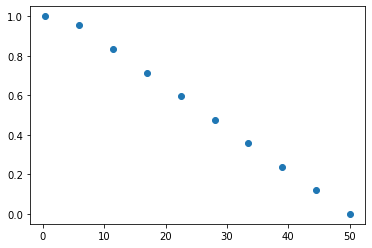

In [44]:
data = np.array(IP_List)
m,b = np.polyfit(data[:,0], data[:,1], 1)
print(m,b)
plt.scatter(data[:,0], data[:,1])

In [8]:
[print('{}\t{}'.format(rct.id, rct.reaction)) for rct in model.metabolites.get_by_id('meoh[e]').reactions];

Ex_meoh	meoh[e] --> 
METOHte	meoh[c] <=> meoh[e]


In [68]:
bio = np.linspace(.0,.16,10)
Substrate = 'meoh'
Product = 'succ[c]' #isoprene[c]
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
flux=10
Suc_List = list()
for bioi in bio:
    with model as md:
        md.reactions.get_by_id('BIOMASS').lower_bound = bioi
        md = set_ObjGSMM(md, Product)
        md = set_SubiOpol(md, [Substrate], flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        Suc_List.append([bioi, Yield])

In [67]:
bio = np.linspace(.0,.16,10)
Substrate = 'meoh'
Product = 'isoprene[c]' 
Cnum = countCinFormula(model.metabolites.get_by_id(Product).formula)
flux=10
IP_List = list()
for bioi in bio:
    with model as md:
        md.reactions.get_by_id('BIOMASS').lower_bound = bioi
        md = set_ObjGSMM(md, Product)
        md = set_SubiOpol(md, [Substrate], flux)
        sol = md.optimize()
        Yield = sol.fluxes['DM_{}'.format(Product)]*Cnum/flux
        IP_List.append([bioi, Yield])

/home/ulf/anaconda3/envs/iambjudas/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


-3.473400207748964 0.5471819054976207


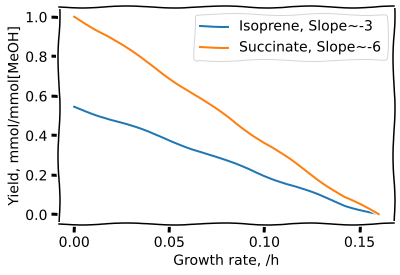

In [73]:
ipdata = np.array(IP_List)
sucdata = np.array(Suc_List)
m,n = np.polyfit(ipdata[:,0], ipdata[:,1], 1)
a,b = np.polyfit(sucdata[:,0], sucdata[:,1], 1)
print(m,n)
with plt.xkcd():
    plt.plot(ipdata[:,0], ipdata[:,1])
    plt.plot(sucdata[:,0], sucdata[:,1])
    plt.xlabel('Growth rate, /h')
    plt.ylabel('Yield, mmol/mmol[MeOH]')
    plt.legend(['Isoprene, Slope~{}'.format(int(m)), 'Succinate, Slope~{}'.format(int(a))])

plt.savefig('Yields-VS-Growth_Isoprene+Suc_Opol.png')